In [2]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np

import functions.eddy_feedback as ef 
import functions.data_wrangling as data 

# Northern Hemisphere

In [3]:
# import dataset for maths servers
ds = xr.open_mfdataset('/home/links/ct715/data_storage/PAMIP/processed_monthly/efp_pd_non-regridded/FGOALS-f3-L_1.1_ubar_epfy_divFy.nc',
                            parallel=True, chunks={'time': 31})

ds = data.seasonal_mean(ds, season='djf')
ds = data.data_checker1000(ds)
ds = ds.mean('time')
ds

<xarray.Dataset>
Dimensions:  (ens_ax: 100, level: 8, lat: 180)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * level    (level) float64 1e+03 850.0 700.0 500.0 250.0 100.0 50.0 10.0
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, level, lat) float32 dask.array<chunksize=(100, 8, 180), meta=np.ndarray>
    epfy     (ens_ax, level, lat) float32 dask.array<chunksize=(100, 8, 180), meta=np.ndarray>
    divFy    (ens_ax, level, lat) float64 dask.array<chunksize=(100, 8, 180), meta=np.ndarray>

### Zonal-mean zonal wind (DJF)

In [4]:
# define zonal mean zonal wind
u = ds.ubar

# slice data at 500hPA and set EFP boundaries
u = u.sel( level = 500. )
u = u.where( u.lat >= 25., drop=True )
u = u.where( u.lat <= 75., drop=True )

# flip axes so time on x-axis
u = u.transpose()
u

<xarray.DataArray 'ubar' (lat: 50, ens_ax: 100)>
dask.array<transpose, shape=(50, 100), dtype=float32, chunksize=(50, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.5 26.5 27.5 28.5 29.5 ... 70.5 71.5 72.5 73.5 74.5
    level    float64 500.0
Dimensions without coordinates: ens_ax

### DJF Northward EP Flux Divergence

In [5]:
# separate into interannual means
# div1 = ds.div1_pr / 86400 
div1 = ds.divFy

# slice data at 500hPA and set EFP boundaries
div1 = div1.sel( level = 500. )
div1 = div1.where( div1.lat >= 25., drop=True )
div1 = div1.where( div1.lat <= 75., drop=True )

# flip axes so time on x-axis
div1 = div1.transpose()

### Covariance

In [6]:
uanom = (u- u.mean('ens_ax'))
div1anom = (div1- div1.mean('ens_ax') )

prod = uanom*div1anom

### Correlation

In [7]:
ustd = u.std()
div1std = div1.std()

corr = prod / (ustd * div1std)


# Plot all figures

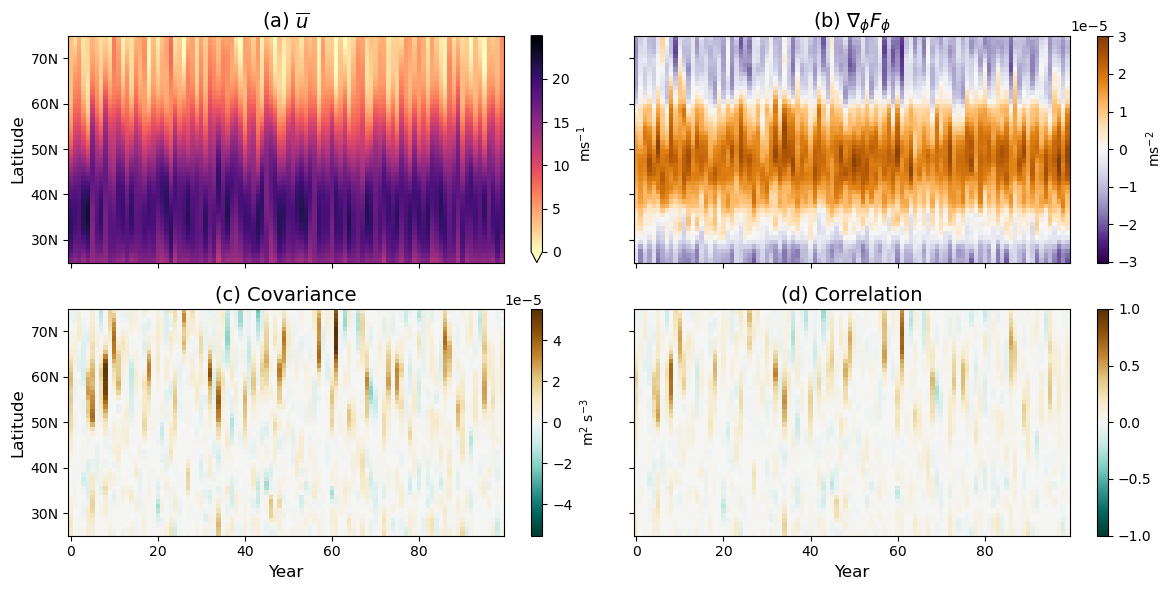

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(12,6))

# plot ubar
u.plot(ax=axs[0,0], cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
axs[0,0].set_yticks(np.arange(30,80, 10))
axs[0,0].set_yticklabels(['30N', '40N', '50N', '60N', '70N'])
axs[0,0].set_title('(a) $\\overline{u}$', fontsize=14)
axs[0,0].set_ylabel('Latitude', fontsize=12)
axs[0,0].set_xlabel('')


# plot div1
div1.plot(ax=axs[0,1], cmap='PuOr_r',
       cbar_kwargs={'label': 'ms$^{-2}$'})
axs[0,1].set_title('(b) $\\nabla_\\phi F_\\phi$', fontsize=14)
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')

# plot covariance
prod.plot(ax=axs[1,0], cmap='BrBG_r', cbar_kwargs={'label': 'm$^2$ s$^{-3}$'})#, 'ticks':[-8e-5,-4e-5,0,4e-5,8e-5]})
axs[1,0].set_title('(c) Covariance', fontsize=14)
axs[1,0].set_ylabel('Latitude', fontsize=12)
axs[1,0].set_xlabel('Year', fontsize=12)

# plot correlation
corr.plot(ax=axs[1,1], cmap='BrBG_r', vmin=-1., vmax=1.,
          cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]})
axs[1,1].set_title('(d) Correlation', fontsize=14)
axs[1,1].set_ylabel('')
axs[1,1].set_xlabel('Year', fontsize=12)

# fig.suptitle('Figure 3: Eddy Feedback Parameter at 500hPa', fontsize=16)

plt.tight_layout()
plt.show()

### Matching colour bar

In [9]:
# fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(12,6))

# # plot ubar
# u.plot(ax=axs[0,0], cmap='magma_r', vmin=0, vmax=25,
#        cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
# axs[0,0].set_yticks(np.arange(30,80, 10))
# axs[0,0].set_yticklabels(['30N', '40N', '50N', '60N', '70N'])
# axs[0,0].set_title('(a) $\\overline{u}$', fontsize=14)
# axs[0,0].set_ylabel('Latitude', fontsize=12)
# axs[0,0].set_xlabel('')


# # plot div1
# div1.plot(ax=axs[0,1], cmap='PuOr_r',
#        cbar_kwargs={'label': 'ms$^{-2}$'})
# axs[0,1].set_title('(b) $\\nabla_\\phi F_\\phi$', fontsize=14)
# axs[0,1].set_ylabel('')
# axs[0,1].set_xlabel('')

# # plot covariance
# # Ensure that vmin and vmax are the same as in the first subplot
# prod.plot(ax=axs[1,0], cmap='BrBG_r', vmin=-8e-5, vmax=8e-5, 
#           cbar_kwargs={'label': 'm$^2$ s$^{-3}$', 'ticks':[-8e-5,-4e-5,0,4e-5,8e-5]})
# axs[1,0].set_title('(c) Covariance', fontsize=14)
# axs[1,0].set_ylabel('Latitude', fontsize=12)
# axs[1,0].set_xlabel('Ensemble Member', fontsize=12)

# # plot correlation
# corr.plot(ax=axs[1,1], cmap='BrBG_r', vmin=-1., vmax=1.,
#           cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]})
# axs[1,1].set_title('(d) Correlation', fontsize=14)
# axs[1,1].set_ylabel('')
# axs[1,1].set_xlabel('Ensemble Member', fontsize=12)

# plt.tight_layout()
# plt.show()


# Southern Hemisphere

In [10]:
# import dataset for maths servers
ds = xr.open_mfdataset('/home/links/ct715/data_storage/PAMIP/processed_monthly/efp_pd_non-regridded/FGOALS-f3-L_1.1_ubar_epfy_divFy.nc',
                            parallel=True, chunks={'time': 31})

ds = data.seasonal_mean(ds, season='jas')
ds = data.data_checker1000(ds)
ds = ds.mean('time')
ds

<xarray.Dataset>
Dimensions:  (ens_ax: 100, level: 8, lat: 180)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * level    (level) float64 1e+03 850.0 700.0 500.0 250.0 100.0 50.0 10.0
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, level, lat) float32 dask.array<chunksize=(100, 8, 180), meta=np.ndarray>
    epfy     (ens_ax, level, lat) float32 dask.array<chunksize=(100, 8, 180), meta=np.ndarray>
    divFy    (ens_ax, level, lat) float64 dask.array<chunksize=(100, 8, 180), meta=np.ndarray>

### Zonal-mean zonal wind (DJF)

In [11]:
# define zonal mean zonal wind
u = ds.ubar

# slice data at 500hPA and set EFP boundaries
u = u.sel( level = 500. )
u = u.where( u.lat >= -75., drop=True )
u = u.where( u.lat <= -25., drop=True )

# flip axes so time on x-axis
u = u.transpose()

### DJF Northward EP Flux Divergence

In [12]:
# separate into interannual means
# div1 = ds.div1_pr / 86400 
div1 = ds.divFy

# slice data at 500hPA and set EFP boundaries
div1 = div1.sel( level = 500. )
div1 = div1.where( div1.lat >= -75., drop=True )
div1 = div1.where( div1.lat <= -25., drop=True )

# flip axes so time on x-axis
div1 = div1.transpose()

### Covariance

In [13]:
uanom = (u- u.mean('ens_ax'))
div1anom = (div1- div1.mean('ens_ax') )

prod = uanom*div1anom

### Correlation

In [14]:
ustd = u.std()
div1std = div1.std()

corr = prod / (ustd * div1std)


# Plot all figures

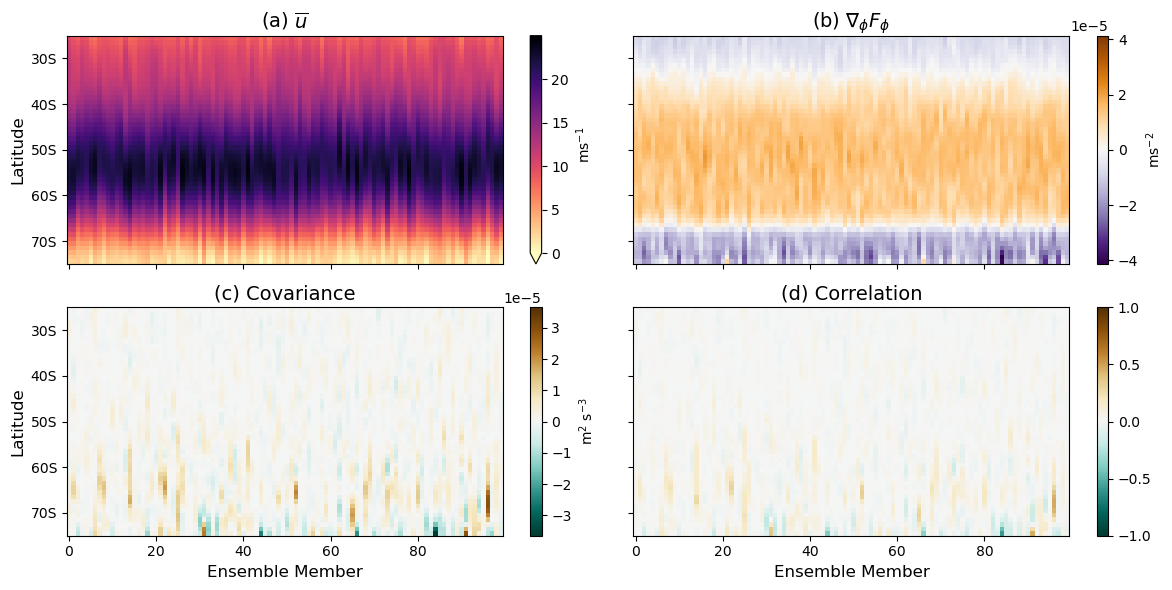

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(12,6))

# plot ubar
u.plot(ax=axs[0,0], cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
axs[0,0].set_yticks(np.arange(-70,-20, 10))
axs[0,0].set_yticklabels(['70S', '60S', '50S', '40S', '30S'])
axs[0,0].set_title('(a) $\\overline{u}$', fontsize=14)
axs[0,0].set_ylabel('Latitude', fontsize=12)
axs[0,0].set_xlabel('')

# plot div1
div1.plot(ax=axs[0,1], cmap='PuOr_r',
       cbar_kwargs={'label': 'ms$^{-2}$'})
axs[0,1].set_title('(b) $\\nabla_\\phi F_\\phi$', fontsize=14)
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')

# plot covariance
# Ensure that vmin and vmax are the same as in the first subplot
prod.plot(ax=axs[1,0], cmap='BrBG_r', cbar_kwargs={'label': 'm$^2$ s$^{-3}$',})
axs[1,0].set_title('(c) Covariance', fontsize=14)
axs[1,0].set_ylabel('Latitude', fontsize=12)
axs[1,0].set_xlabel('Ensemble Member', fontsize=12)

# plot correlation
corr.plot(ax=axs[1,1], cmap='BrBG_r', vmin=-1., vmax=1.,
          cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]})
axs[1,1].set_title('(d) Correlation', fontsize=14)
axs[1,1].set_ylabel('')
axs[1,1].set_xlabel('Ensemble Member', fontsize=12)

plt.tight_layout()
plt.show()


### Matching colour bar

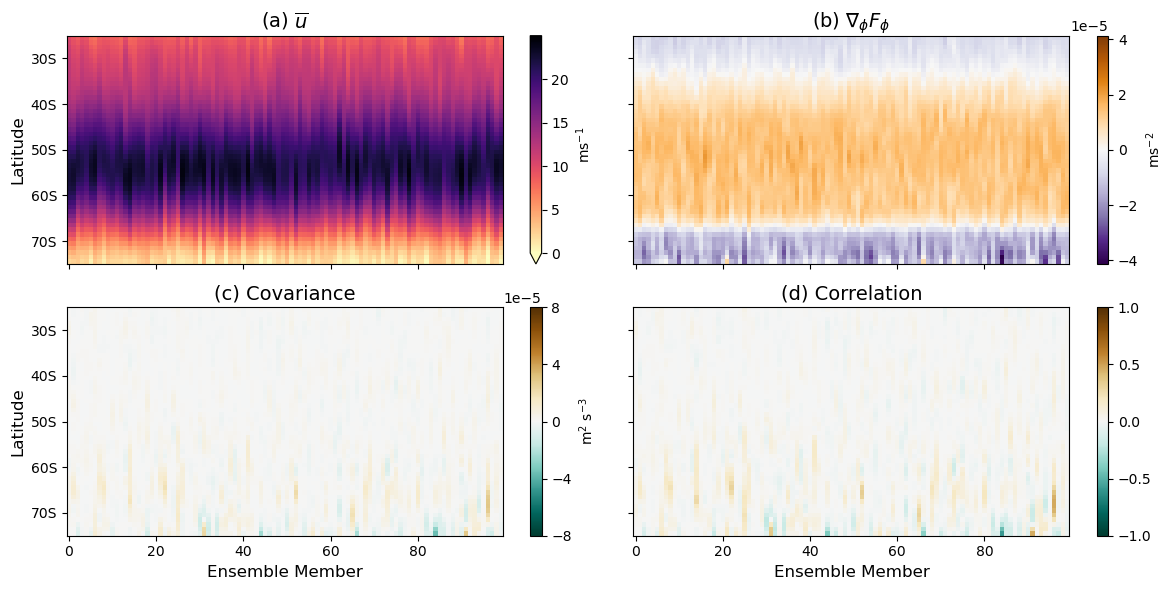

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(12,6))

# plot ubar
u.plot(ax=axs[0,0], cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
axs[0,0].set_yticks(np.arange(-70,-20, 10))
axs[0,0].set_yticklabels(['70S', '60S', '50S', '40S', '30S'])
axs[0,0].set_title('(a) $\\overline{u}$', fontsize=14)
axs[0,0].set_ylabel('Latitude', fontsize=12)
axs[0,0].set_xlabel('')

# plot div1
div1.plot(ax=axs[0,1], cmap='PuOr_r',
       cbar_kwargs={'label': 'ms$^{-2}$'})
axs[0,1].set_title('(b) $\\nabla_\\phi F_\\phi$', fontsize=14)
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')

# plot covariance
# Ensure that vmin and vmax are the same as in the first subplot
prod.plot(ax=axs[1,0], cmap='BrBG_r', vmin=-8e-5, vmax=8e-5, 
          cbar_kwargs={'label': 'm$^2$ s$^{-3}$', 'ticks':[-8e-5,-4e-5,0,4e-5,8e-5]})
axs[1,0].set_title('(c) Covariance', fontsize=14)
axs[1,0].set_ylabel('Latitude', fontsize=12)
axs[1,0].set_xlabel('Ensemble Member', fontsize=12)

# plot correlation
corr.plot(ax=axs[1,1], cmap='BrBG_r', vmin=-1., vmax=1.,
          cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]})
axs[1,1].set_title('(d) Correlation', fontsize=14)
axs[1,1].set_ylabel('')
axs[1,1].set_xlabel('Ensemble Member', fontsize=12)

plt.tight_layout()
plt.show()
